![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Medical_Language_Models/April_2025/Notebooks/Dicom_Obfuscation_Methods.ipynb)

<!DOCTYPE html>
<html>
<body>

<h1>DICOM Pixel Rendering:</h1>

<p>This notebook provides a hands-on demonstration of rendering obfuscated PHI in place of original PHI, an alternative to pixel deidentification. We will walk through the necessary steps and provide code examples.</p>

<h2>Environment Setup:</h2>

<ul>
    <li><strong>Google Colab (Recommended):</strong> If you are using Google Colab, the environment is generally pre-configured for many dependencies.</li>
    <li><strong>Local Setup (If not using Colab):</strong>
        <ul>
            <li><strong>Homebrew:</strong> Ensure you have Homebrew installed. (e.g., <code>/bin/bash -c "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/HEAD/install.sh)"</code></li>
            <li><strong>Apache Spark:</strong> Install Apache Spark (e.g., <code>brew install apache-spark</code> By default OpenJDK 17 will be installed.</li>
            <li><strong>OpenJDK 17:</strong> Ensure you have Java Path configured before starting <code>spark-ocr</code> session <code>os.environ['JAVA_HOME'] = '/home/linuxbrew/.linuxbrew/Cellar/openjdk@17/17.0.14'</code></li>
        </ul>
    </li>
</ul>

<h2>Required Libraries:</h2>

<ul>
    <li><strong>Spark-OCR:</strong> This library is crucial for text detection and Optical Character Recognition (OCR) and IO operations related to DICOM images.</li>
    <li><strong>Spark-NLP-Healthcare:</strong> This library provides advanced Named Entity Recognition (NER) models specifically designed for medical text, enabling accurate PHI identification.</li>
    <li><strong>Spark-NLP: </strong>Open Source Library installed automatically with Visual NLP.</li>
</ul>

<img
  src="https://www.johnsnowlabs.com/wp-content/uploads/2023/03/visual_nlp.png"
  alt="Visual NLP Diagram from John Snow Labs"
  style="max-width: 100%; height: auto;" >
</body>
</html>

<h2>Installation Steps</h2>
<ul>
    <li>Make sure license file is present in the same directory, and <strong>license</strong> variable is populated.</li>
    <li>Set Environment Variables.</li>
    <li>Install Visual-NLP, Healthcare-NLP, Pandas and Matplotlib.</li>
    <li><strong>Restart Session!!!!<strong></li>
</ul>

In [ ]:
import json
import os

license = ""

if license and "json" not in license:

    with open(license, "r") as creds_in:
        creds = json.loads(creds_in.read())

        for key in creds.keys():
            os.environ[key] = creds[key]
else:
    raise Exception("License JSON File is not specified")

In [ ]:
!python3 -m pip install -q --upgrade spark-ocr==$OCR_VERSION --user --extra-index-url https://pypi.johnsnowlabs.com/$SPARK_OCR_SECRET

In [ ]:
!python3 -m pip install -q --upgrade spark-nlp-jsl==$JSL_VERSION --extra-index-url https://pypi.johnsnowlabs.com/$SECRET

In [ ]:
!pip install -q pandas matplotlib

In [ ]:
# RESTART SESSION!!!

<h2>Notebook Objectives:</h2>

<p>This notebook will illustrate the following key stages of DICOM pixel rendering:</p>

<ul>
    <li>Loading and processing DICOM images.</li>
    <li>Detecting text within the image pixels using Spark-OCR.</li>
    <li>Performing Optical Character Recognition (OCR) to extract the detected text.</li>
    <li>Identifying PHI entities within the extracted text using Spark-NLP-Healthcare's NER models.</li>
    <li>Running Deidentification stage to generate obfuscated PHI.</li>
    <li>Rendering Obfuscated PHI inplace of original PHI.</li>
</ul>

<p>By following this notebook, you will gain practical experience in building a DICOM pixel rendering pipeline using Spark-OCR and Spark-NLP-Healthcare.</p>

<h2>Start Visual-NLP Session with Healthcare-NLP</h2>

In [ ]:
from sparkocr import start
import os
import json
import time
import shutil

license = ""

if license:
    with open(license, "r") as creds_in:
        creds = json.loads(creds_in.read())

        for key in creds.keys():
            os.environ[key] = creds[key]

# Set Java Path
# Not Required on Google Collab
os.environ['JAVA_HOME'] = '/home/linuxbrew/.linuxbrew/Cellar/openjdk@17/17.0.14'

In [ ]:
extra_configurations = {
    "spark.extraListeners": "com.johnsnowlabs.license.LicenseLifeCycleManager",
}

spark = start(secret=os.environ["SPARK_OCR_SECRET"],
              nlp_secret=os.environ["SECRET"],
              nlp_internal=True,
              nlp_jsl=True,
              nlp_version=os.environ["PUBLIC_VERSION"],
              extra_conf=extra_configurations,
              use_gpu=False)

spark

<h2>Import Transformers and Annotators</h2>

In [ ]:
import os
import sys
import time
from PIL import Image
import io

from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp_jsl
from sparknlp_jsl.annotator import *

import sparkocr
from sparkocr.transformers import *
from sparkocr.utils import *
from sparkocr.enums import *

from pyspark.ml import PipelineModel, Pipeline
from sparknlp.pretrained import PretrainedPipeline
from pyspark.ml import PipelineModel, Pipeline

import pyspark.sql.functions as F

print(f"Spark NLP version: {sparknlp.version()}")
print(f"Spark NLP internal version: {sparknlp_jsl.version()}")
print(f"Spark OCR version: {sparkocr.version()}")

Spark NLP version: 5.5.2
Spark NLP internal version: 5.5.2
Spark OCR version: 5.5.1rc4


<h2>Building the DICOM Pixel Rendering Pipeline</h2>

<p>We'll construct a pipeline designed to extract and deidentify Protected Health Information (PHI) from DICOM images by rendering obfuscated PHI inplace. This process involves several key stages:</p>

<ol>
    <li>
        <strong>DICOM Image Processing Integration:</strong>
        <ul>
            <li>Integrate DICOM image handling, text detection, and Optical Character Recognition (OCR) stages from the Visual NLP library. This allows the pipeline to process DICOM images and extract text from their pixel data.</li>
        </ul>
    </li>
    <li>
        <strong>NER Detection</strong>
        <ul>
            <li>Integrate Document Assembler, Sentence and NER detection stages to create ner_chunks using text from the ocr stage. </li>
        </ul>
    </li>
    <li>
        <strong>Generate Obfuscation</strong>
        <ul>
            <li>With De-Identification stage we are able to generate obfuscated PHI.</li>
        </ul>
    </li>
    <li>
        <strong>Generate Coordinates</strong>
        <ul>
            <li>Once ner_chunks, auxillary mapping and positions have been generated coordinates for PHI information can be generated, which is then fed into ImageDrawRegions.</li>
        </ul>
    </li>
</ol>

In [ ]:
dicom_to_image = DicomToImageV3() \
    .setInputCols(["content"]) \
    .setOutputCol("image_raw") \
    .setKeepInput(True)

text_detector = ImageTextDetector.pretrained("image_text_detector_mem_opt", "en", "clinical/ocr") \
    .setInputCol("image_raw") \
    .setOutputCol("text_regions") \
    .setScoreThreshold(0.7) \
    .setWithRefiner(False) \
    .setTextThreshold(0.4) \
    .setLinkThreshold(0.5) \
    .setSizeThreshold(1) \
    .setUseGPU(False) \
    .setWidth(0) \
    .setHeight(0)

ocr_text = ImageToTextV2.pretrained("ocr_large_printed_v2_opt", "en", "clinical/ocr") \
    .setRegionsColumn("text_regions") \
    .setInputCols(["image_raw"]) \
    .setOutputCol("text") \
    .setOutputFormat(OcrOutputFormat.TEXT_WITH_POSITIONS) \
    .setGroupImages(False) \
    .setKeepInput(True) \
    .setUseGPU(False) \
    .setUseCaching(True) \
    .setBatchSize(4)

document_assembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document") \
    .setCleanupMode("disabled")

sentence_detector = SentenceDetectorDLModel.pretrained("sentence_detector_dl","xx")\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols("sentence", "token")\
    .setOutputCol("embeddings")

glove_embeddings = WordEmbeddingsModel.pretrained('glove_100d') \
      .setInputCols(['sentence', 'token']) \
      .setOutputCol('embeddings_glove')

clinical_ner_glove = MedicalNerModel.pretrained("ner_deid_generic_glove", "en", "clinical/models") \
      .setInputCols(["sentence", "token", "embeddings_glove"]) \
      .setOutputCol("ner_glove")

ner_converter_glove = NerConverterInternalModel() \
        .setInputCols(["sentence", "token", "ner_glove"]) \
        .setOutputCol("ner_chunk_glove") \
        .setThreshold(0.7) \
        .setWhiteList(['ID', 'NAME', 'AGE', 'SEX', 'PERSON', 'DATE', 'DOCTOR', 'PATIENT'])

clinical_ner_sub_glove = MedicalNerModel.pretrained("ner_deid_subentity_glove", "en", "clinical/models") \
      .setInputCols(["sentence", "token", "embeddings_glove"]) \
      .setOutputCol("ner_sub_glove")

ner_converter_sub_glove = NerConverterInternalModel() \
        .setInputCols(["sentence", "token", "ner_sub_glove"]) \
        .setOutputCol("ner_chunk_sub_glove") \
        .setThreshold(0.7) \
        .setWhiteList(['ID', 'NAME', 'AGE', 'SEX', 'PERSON', 'DATE', 'DOCTOR', 'PATIENT'])

clinical_ner_multi = MedicalNerModel.pretrained("ner_deid_name_multilingual_clinical_langtest", "xx", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner_multi")

ner_converter_multi = NerConverterInternalModel() \
        .setInputCols(["sentence", "token", "ner_multi"]) \
        .setOutputCol("ner_chunk_multi") \
        .setThreshold(0.7) \
        .setWhiteList(['ID', 'NAME', 'AGE', 'SEX', 'PERSON', 'DATE', 'DOCTOR', 'PATIENT'])

clinical_ner_large = MedicalNerModel.pretrained("ner_deid_large", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner_deid_large")

ner_converter_large = NerConverterInternalModel() \
        .setInputCols(["sentence", "token", "ner_deid_large"]) \
        .setOutputCol("ner_chunk_large") \
        .setThreshold(0.7) \
        .setWhiteList(['ID', 'NAME', 'AGE', 'PERSON', 'DATE', 'DOCTOR', 'PATIENT'])

chunk_merger = ChunkMergeApproach()\
    .setInputCols('ner_chunk_glove', "ner_chunk_sub_glove", "ner_chunk_multi", "ner_chunk_large")\
    .setOutputCol('merged_ner_chunk') \
    .setMergeOverlapping(True)

deid_obfuscated = DeIdentification() \
    .setInputCols(["sentence", "token", "merged_ner_chunk"]) \
    .setOutputCol("obfuscated") \
    .setMode("obfuscate") \
    .setKeepMonth(True) \
    .setKeepYear(True) \
    .setObfuscateDate(True) \
    .setSameEntityThreshold(0.7) \
    .setKeepTextSizeForObfuscation(True) \
    .setFakerLengthOffset(10) \
    .setReturnEntityMappings(True) \
    .setDays(2) \
    .setMappingsColumn("aux") \
    .setIgnoreRegex(True) \
    .setGroupByCol("path") \
    .setSeed(40) \
    .setConsistentObfuscation(True)

position_finder = PositionFinder() \
    .setInputCols("merged_ner_chunk") \
    .setOutputCol("coordinates") \
    .setPageMatrixCol("positions")

draw_regions = ImageDrawRegions()  \
    .setInputCol("image_raw")  \
    .setInputChunkMappingCol("aux") \
    .setInputRegionsCol("coordinates")  \
    .setOutputCol("image_with_patches")  \
    .setPatchImages(True) \
    .setUseContrastTextColor(False) \
    .setPageMatrixCol("positions")

stages = [
    dicom_to_image,
    text_detector,
    ocr_text,
    document_assembler,
    sentence_detector,
    tokenizer,
    embeddings,
    glove_embeddings,
    clinical_ner_glove,
    ner_converter_glove,
    clinical_ner_sub_glove,
    ner_converter_sub_glove,
    clinical_ner_multi,
    ner_converter_multi,
    clinical_ner_large,
    ner_converter_large,
    chunk_merger,
    deid_obfuscated,
    position_finder,
    draw_regions
]

dicom_pipe = Pipeline(stages=stages)

In [ ]:
stages

[DicomToImageV3_a3d61cfa7af1,
 ImageTextDetectorCraft_79f1aa25f8cb,
 ImageToTextV2_04f87bcbb0b2,
 DocumentAssembler_dfd46659db39,
 SentenceDetectorDLModel_8aaebf7e098e,
 Tokenizer_8c2c5eb91c28,
 WORD_EMBEDDINGS_MODEL_9004b1d00302,
 WORD_EMBEDDINGS_MODEL_48cffc8b9a76,
 MedicalNerModel_1c278433019e,
 NerConverterInternalModel_0312e6ad7dfb,
 MedicalNerModel_af9c2512011c,
 NerConverterInternalModel_e64ce91ceda1,
 MedicalNerModel_2cb37763b81b,
 NerConverterInternalModel_dec66822739f,
 MedicalNerModel_15975bb9777e,
 NerConverterInternalModel_0f6d710dcc49,
 ChunkMergeApproach_c3bbed3fcb22,
 DeIdentification_60565fb1e5de,
 PositionFinder_b2e5e79cbbce,
 ImageDrawRegions_f47b141d446e]

<h3>Load a Single Dicom File and View Input Dicom</h3>

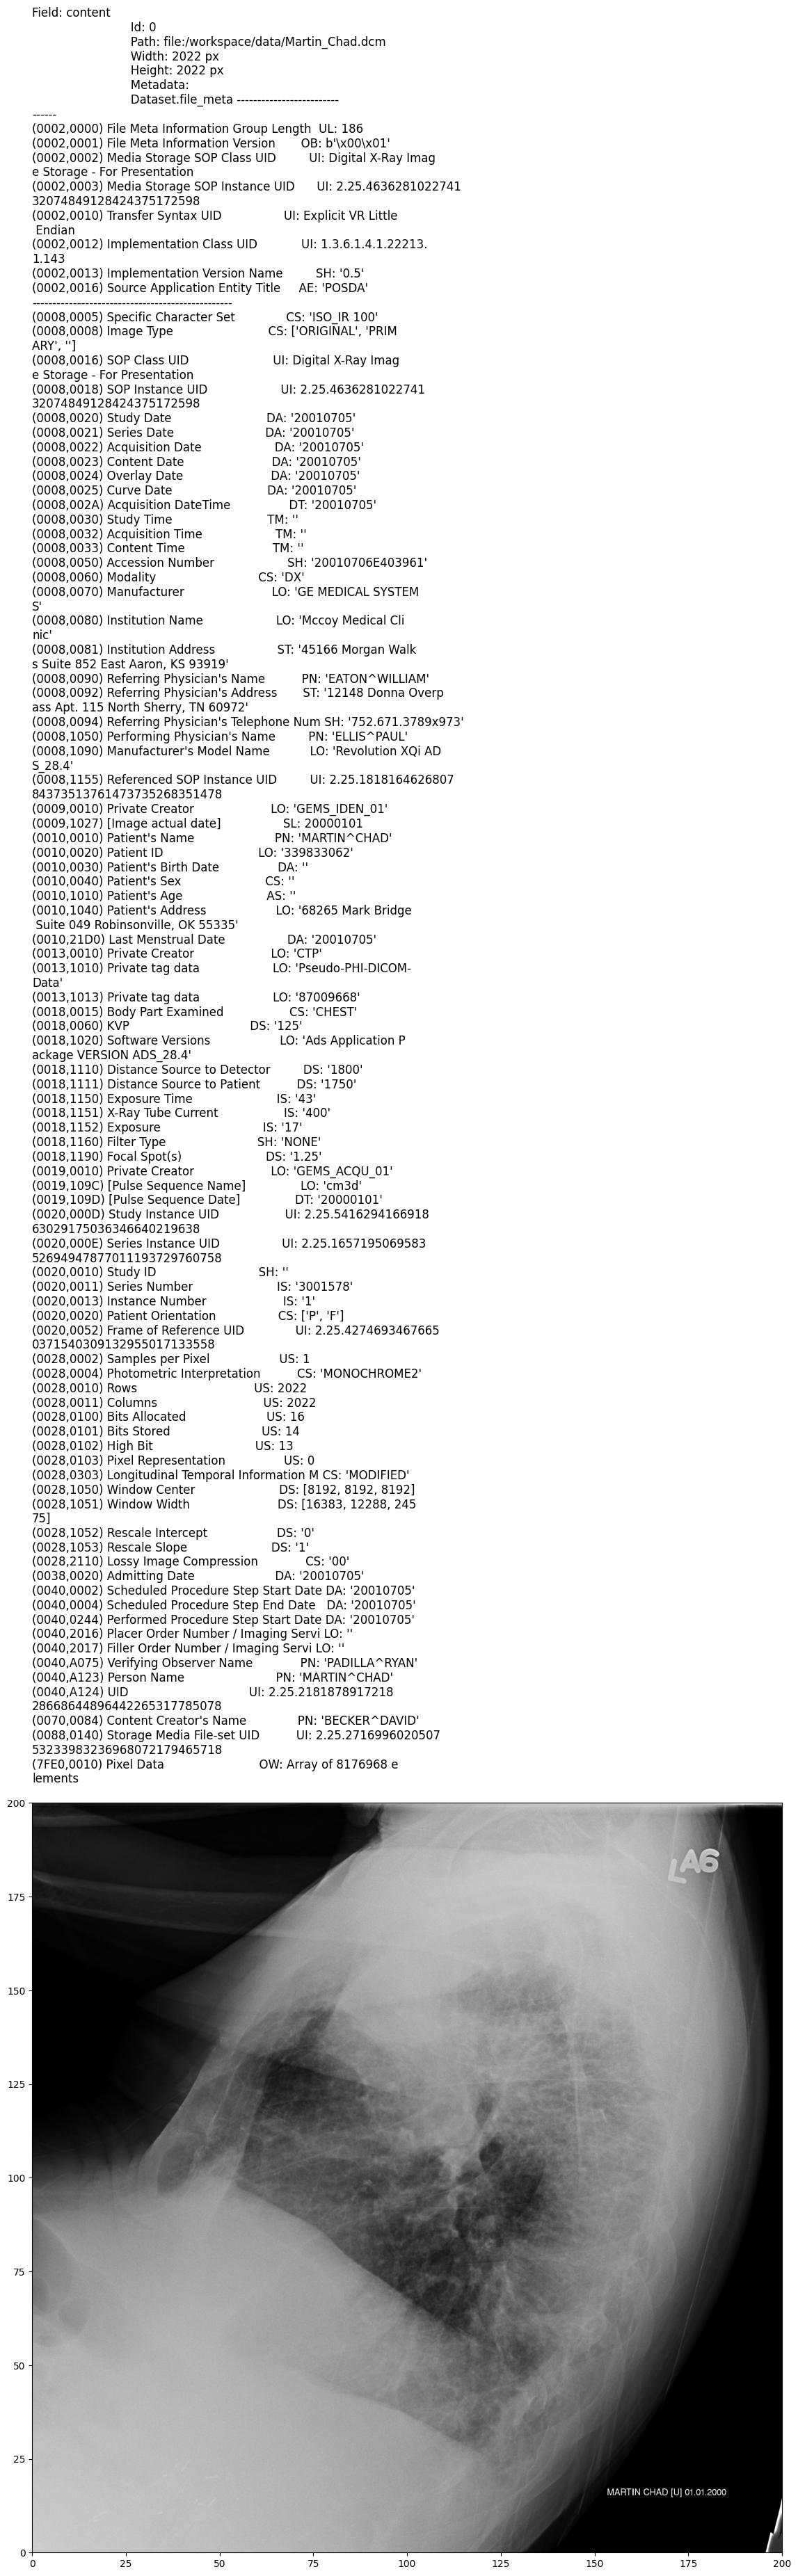

In [ ]:
df = spark.read.format("binaryFile").load("./data/Martin_Chad.dcm")

display_dicom(df, "content")

In [ ]:
result = dicom_pipe.fit(df).transform(df).cache()

result.columns

['image_raw',
 'pagenum',
 'path',
 'modificationTime',
 'length',
 'content',
 'text_regions',
 'text',
 'confidence',
 'positions',
 'document',
 'sentence',
 'token',
 'embeddings',
 'embeddings_glove',
 'ner_glove',
 'ner_chunk_glove',
 'ner_sub_glove',
 'ner_chunk_sub_glove',
 'ner_multi',
 'ner_chunk_multi',
 'ner_deid_large',
 'ner_chunk_large',
 'merged_ner_chunk',
 'obfuscated',
 'aux',
 'coordinates',
 'image_with_patches',
 'exception']

<h2>Visualization of Detected Text Regions</h2>

In [ ]:
# View the detected regions
result.select(F.explode("text_regions").alias("detected_regions")).show(10, False)

25/04/06 00:18:48 WARN DAGScheduler: Broadcasting large task binary with size 2027.5 KiB
00:18:51, INFO Run DicomToImageV3                                   (0 + 1) / 1]
00:18:51, INFO DicomToImageV3: Number of frames: 1
25/04/06 00:19:07 WARN DAGScheduler: Broadcasting large task binary with size 1473.5 KiB
25/04/06 00:19:08 WARN DAGScheduler: Broadcasting large task binary with size 1486.3 KiB


+---------------------------------------------------------------------------------+
|detected_regions                                                                 |
+---------------------------------------------------------------------------------+
|{0, 0, 1791.3389, 165.63326, 83.883194, 150.16183, 0.95686275, 0, 72.80146, true}|
|{0, 0, 1598.0, 1862.0, 24.0, 92.0, 0.9764706, 0, 90.0, true}                     |
|{0, 0, 1684.0, 1862.0, 24.0, 68.0, 0.92156863, 0, 90.0, true}                    |
|{0, 0, 1818.0, 1862.0, 24.0, 116.0, 0.94509804, 0, 90.0, true}                   |
|{0, 0, 1741.0, 1866.0, 28.0, 38.0, 0.8117647, 0, 90.0, true}                     |
+---------------------------------------------------------------------------------+



25/04/06 00:19:10 WARN DAGScheduler: Broadcasting large task binary with size 1486.0 KiB



    Image #0:
    Origin: file:/workspace/data/Martin_Chad.dcm
    Resolution: 0 dpi
    Width: 2022 px
    Height: 2022 px
    Mode: 10
    Number of channels: 1


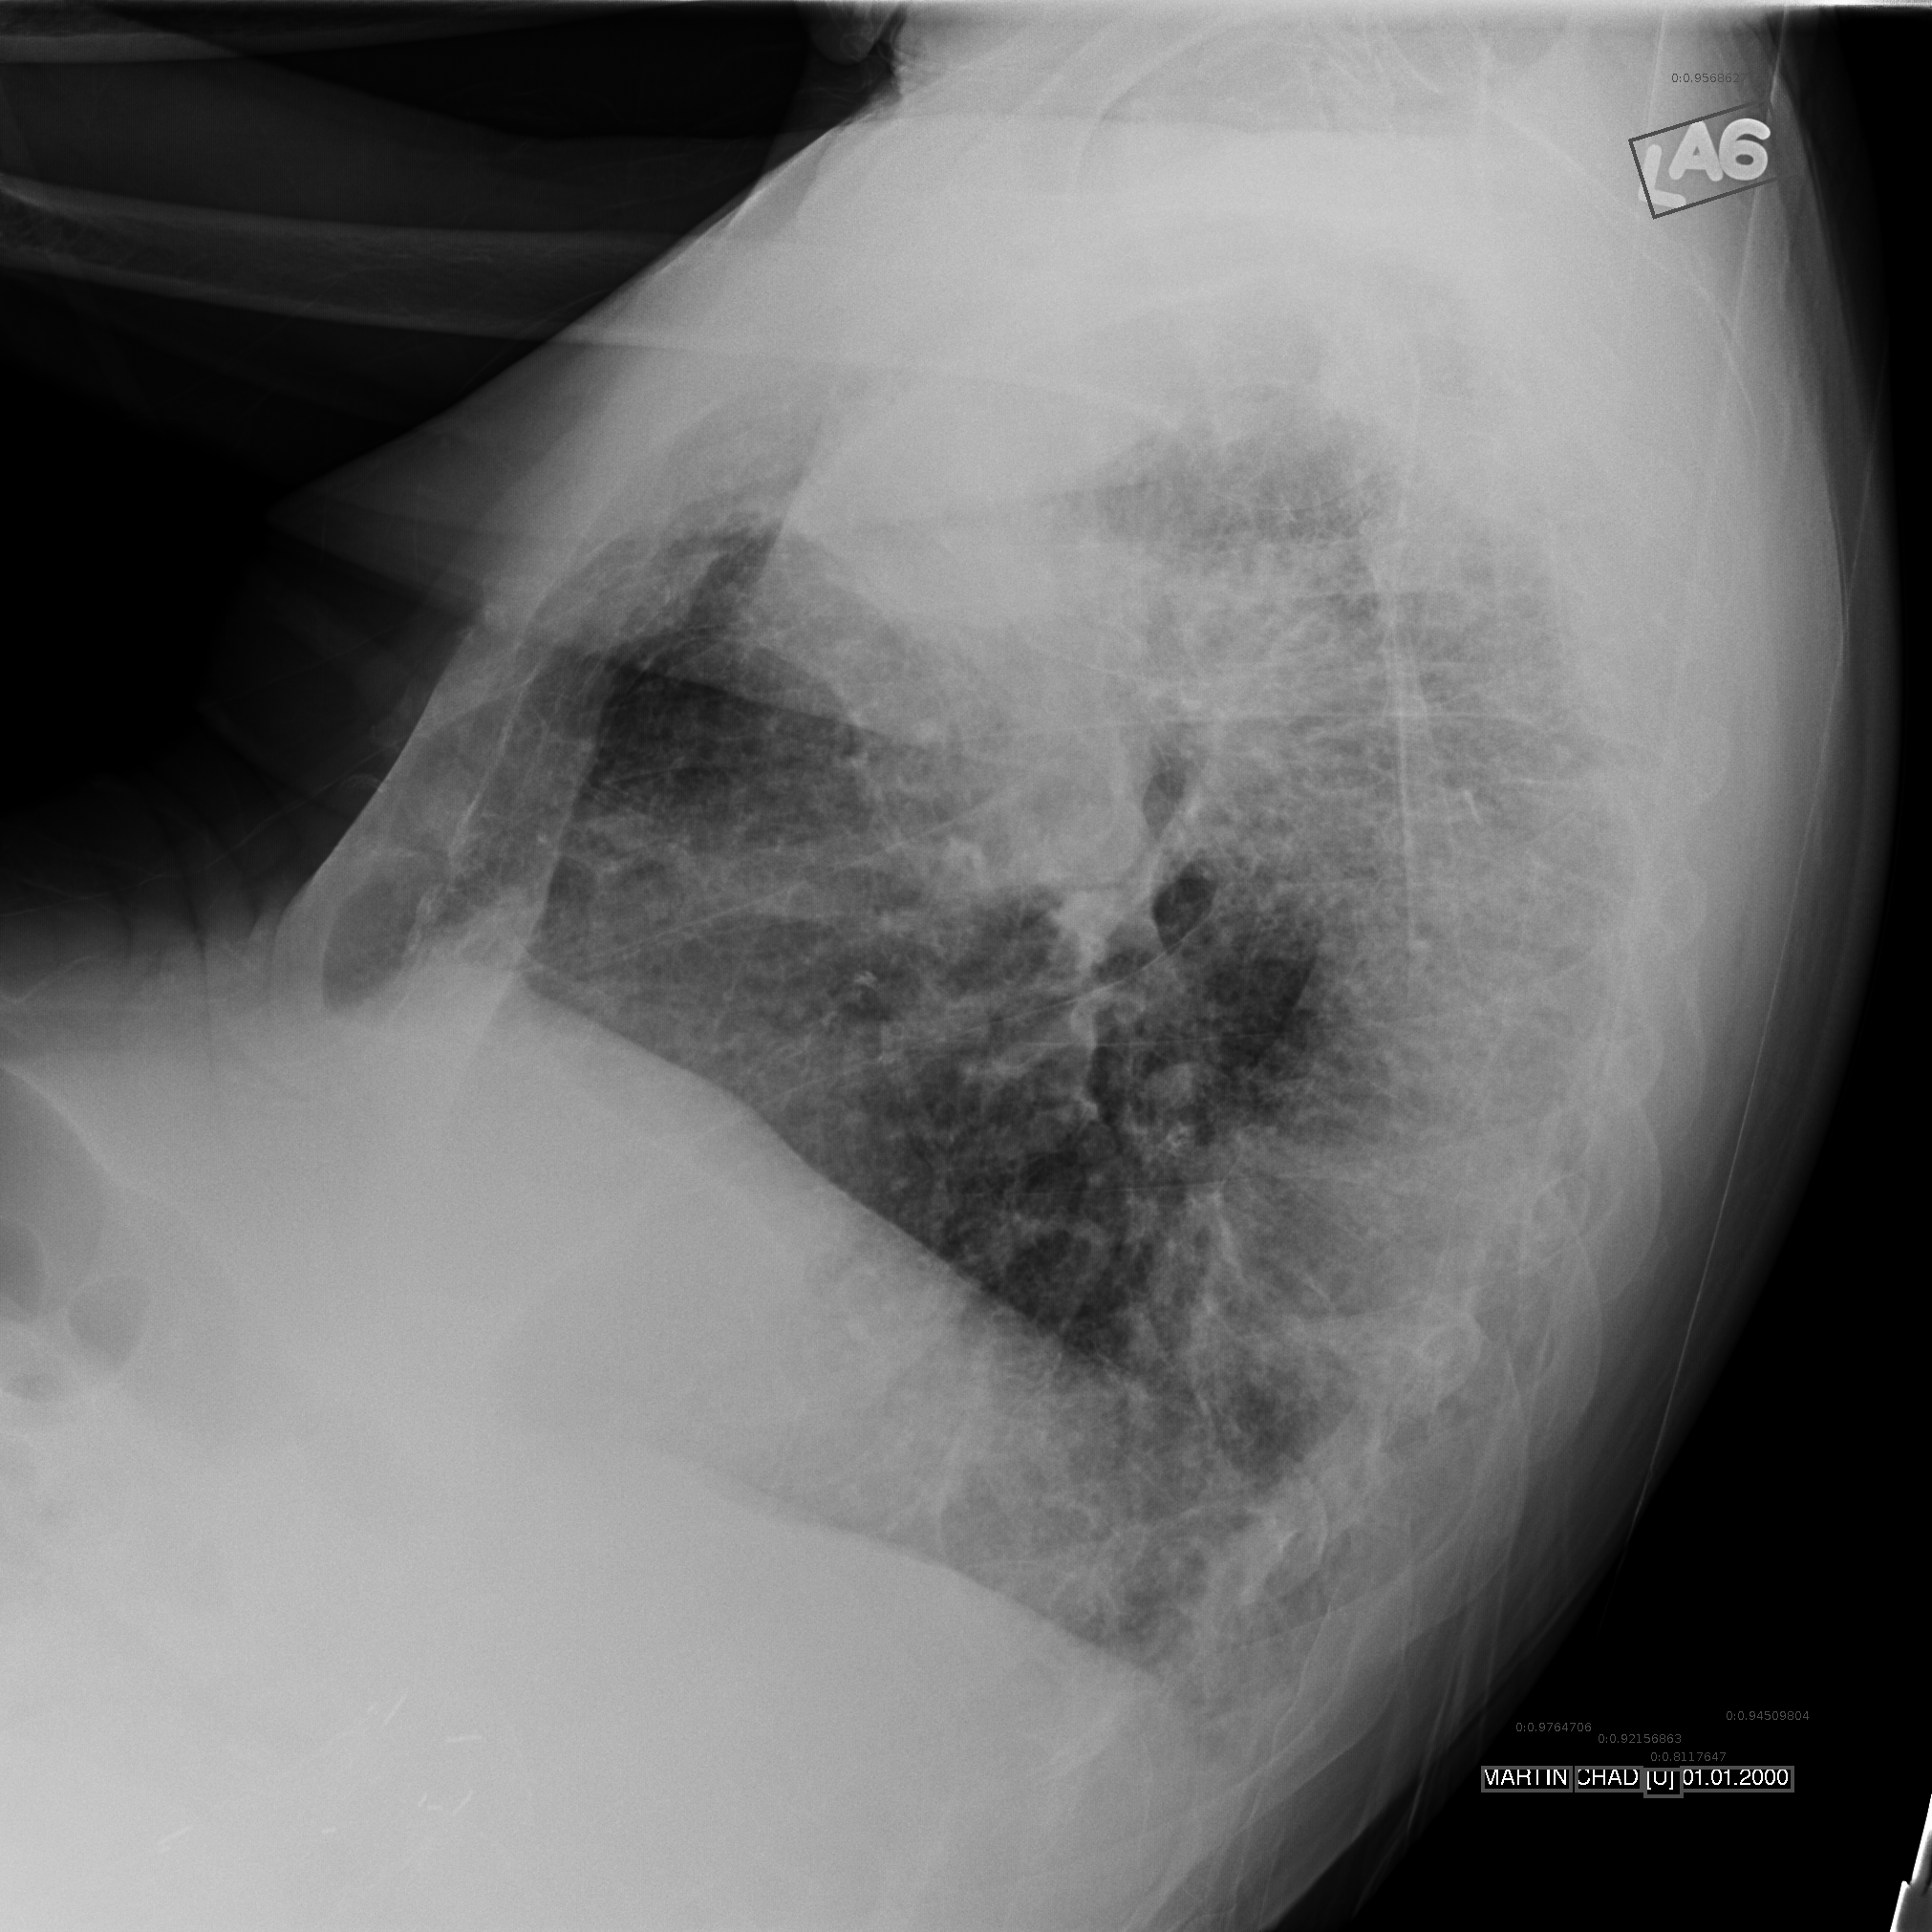

In [ ]:
draw = ImageDrawRegions() \
  .setInputCol("image_raw") \
  .setInputRegionsCol("text_regions") \
  .setRectColor(Color.red) \
  .setOutputCol("image_with_regions")

display_images(draw.transform(result), "image_with_regions")

<h2>View NER Results</h2>

In [ ]:
result.select(F.explode(F.arrays_zip(result.merged_ner_chunk.result, result.merged_ner_chunk.metadata)).alias("cols")) \
                      .select(F.expr("cols['0']").alias("ner_chunk"),
                              F.expr("cols['1']['confidence']").alias("confidence"),
                              F.expr("cols['1']['entity']").alias("chunk_class")).show(truncate=False)

+-----------+----------+-----------+
|ner_chunk  |confidence|chunk_class|
+-----------+----------+-----------+
|MARTIN CHAD|0.90885   |NAME       |
|01.01.2000 |0.9999    |DATE       |
+-----------+----------+-----------+



25/04/06 00:19:17 WARN DAGScheduler: Broadcasting large task binary with size 1487.9 KiB


<h2>View Obfuscated Results</h2>

In [ ]:
result.select(F.explode("aux").alias("cols")) \
    .select(
        F.expr("cols.metadata.chunk").alias("ID"),
        F.expr("cols.metadata.entity").alias("Entity Class"),
        F.expr("cols.metadata.beginOriginalChunk").alias("begin"),
        F.expr("cols.metadata.endOriginalChunk").alias("end"),
        F.expr("cols.metadata.confidence").alias("Confidence"),
        F.expr("cols.metadata.originalChunk").alias("Original PHI"),
        F.expr("cols.result").alias("Obfuscated PHI")).show(10, False)

+---+------------+-----+---+----------+------------+--------------+
|ID |Entity Class|begin|end|Confidence|Original PHI|Obfuscated PHI|
+---+------------+-----+---+----------+------------+--------------+
|0  |NAME        |4    |14 |0.90885   |MARTIN CHAD |MARTY SLEET   |
|1  |DATE        |20   |29 |0.9999    |01.01.2000  |03.01.2000    |
+---+------------+-----+---+----------+------------+--------------+



25/04/06 00:19:19 WARN DAGScheduler: Broadcasting large task binary with size 1505.4 KiB


<h2>View Final Rendered Results</h2>

25/04/06 00:19:21 WARN DAGScheduler: Broadcasting large task binary with size 1475.9 KiB


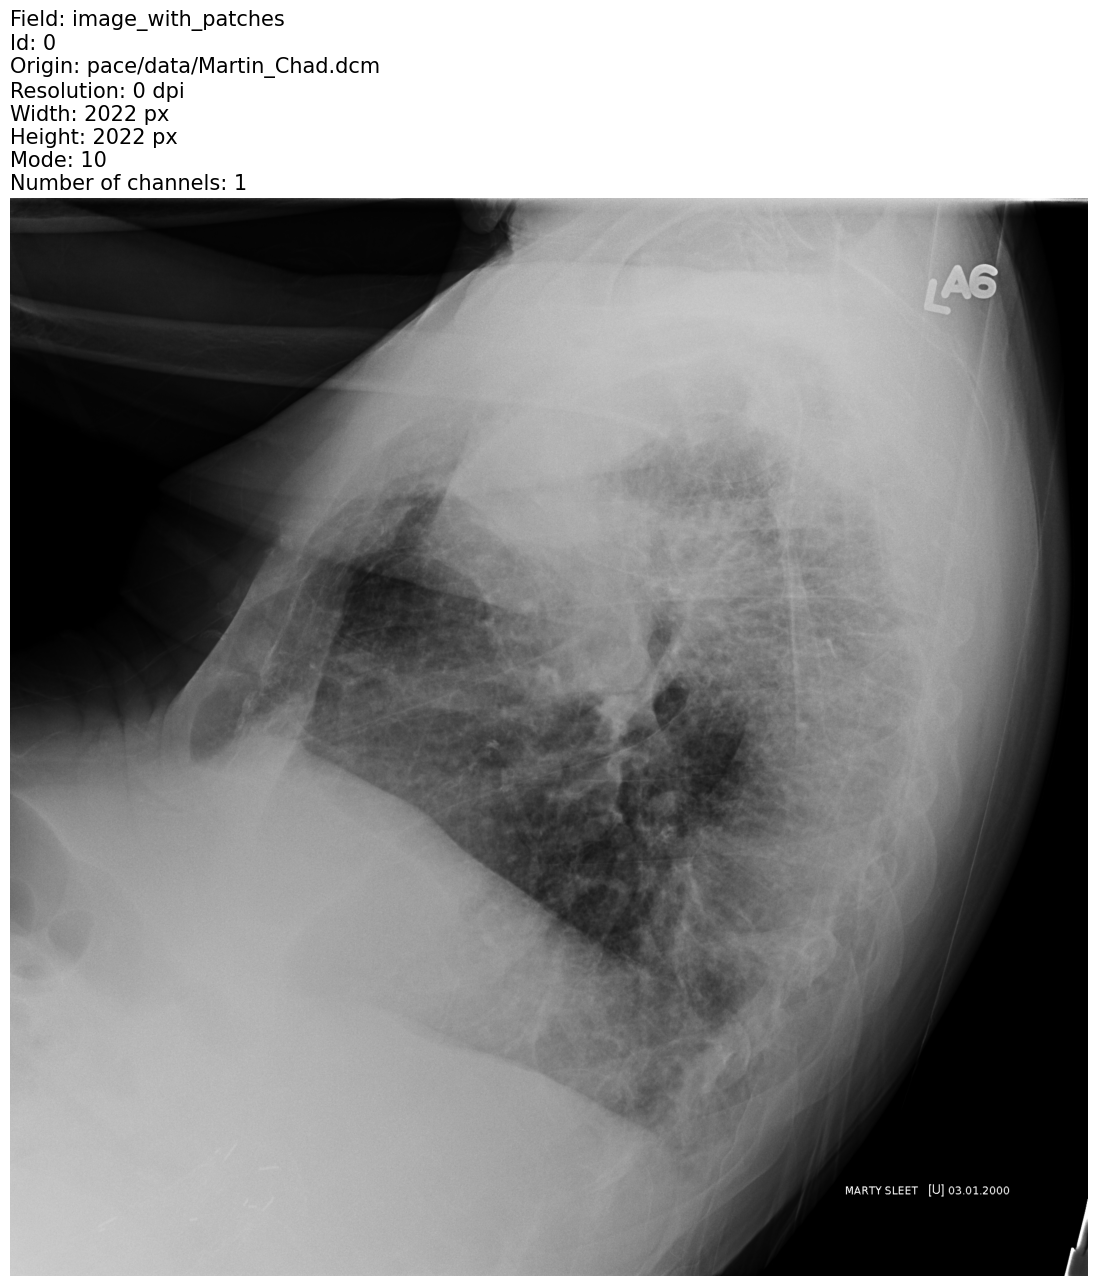

In [ ]:
display_images_horizontal(result, "image_with_patches")